In [1]:
from typing import Tuple, List
from datetime import datetime, timedelta, timezone

import numpy as np

from sgp4.api import Satrec
from sgp4.api import jday
from astropy import coordinates
from astropy.coordinates.builtin_frames import GCRS, ITRS

from SATELLITES import SATELLITES
from coordinate_system.EarhRotating import build_default_rotating_cs
from XtoY.cartesianfromgeo import get_cartesian_geo_from_geo_angles
from coordinate_system.earth_models import get_wgs_84
from XtoY.xyz_rfilam import xyz_to_rfilam

from matplotlib import pyplot as plt

In [47]:
def get_satellite_trajectory(tle2lines: Tuple[str, str], time_points: List[datetime]):
    satellite = Satrec.twoline2rv(*tle2lines)
    jd_fr = np.array([jday(*(point.utctimetuple()[:6])) for point in time_points])
    result = [satellite.sgp4(jd, fr)[1] for jd, fr in jd_fr]
    return np.array(result)



# s = '1 15427U 84123A   20251.91176968  .00000010  00000-0  28072-4 0  9998'
# t = '2 15427  98.9487 206.5692 0014348 199.4765 227.6432 14.16105412844969'
s = '1 15427U 84123A   20251.91176968  .00000010  00000-0  28072-4 0  9998'
t = '2 15427  98.9487 206.5692 0014348 199.4765 227.6432 14.16105412844969'

t0 = datetime(2020, 9, 8, 9, 22, 48, tzinfo=timezone.utc)
time_points = [t0 + timedelta(seconds=i * 10)  for i in range(1000)]
print(time_points[-1])


trajectory = get_satellite_trajectory((s, t), time_points)

print(trajectory)
    


# # широта и долгота ЛК
# lk_coord = [55.930148, 37.518151]
# print("Широта и долгота ЛК", lk_coord)

# # декартовы координты ЛК
# lk_cartesian = get_cartesian_geo_from_geo_angles(latitude=lk_coord[0], longitude=lk_coord[1], model=get_wgs_84())

# print("Декартовы координаты ЛК", lk_cartesian)


# satellite = Satrec.twoline2rv(s, t)

# jd, fr = jday(2020, 9, 9, 14, 00, 0)

# # получаем векторы координат и скорости спутника в конкретный момент времени
# result = satellite.sgp4(jd, fr)

# print("Координаты спутника x, y, z", result[1])
# print("Скорсть спутника v_x, v_y, v_z", result[2])

# # получаем матрицу перехода от ИСО в НеИСО в момент времени data
# data = datetime(2020, 9, 7).timestamp()
# rotator = build_default_rotating_cs()
# rm = rotator.get_matrix(data)

# # координаты в нужной системе отсчета
# result_in_itrs = rm.dot(result[1])
# print("Координаты спутника в НеИСО", result_in_itrs)

# lk_in_itrs = rm.dot(lk_cartesian)
# print("Координаты ЛК в НеИСО в километрах", lk_in_itrs/1000)

2020-09-08 12:09:18+00:00
[[-6191.31571761 -3424.62064665 -1487.27766034]
 [-6209.87616187 -3421.41507939 -1415.49803421]
 [-6227.7809839  -3417.84828845 -1343.56858621]
 ...
 [ 5486.42779415  2071.82412518 -4199.42253689]
 [ 5451.46146617  2043.41695118 -4258.57502009]
 [ 5415.91668957  2014.79295342 -4317.2744816 ]]


In [48]:
rotator = build_default_rotating_cs()
wgs84 = get_wgs_84()

def get_terrestrial_point_coordinates(geo_angles: Tuple[float, float], time_points: List[datetime]):
    coordinates = get_cartesian_geo_from_geo_angles(latitude=geo_angles[0], longitude=geo_angles[1], model=wgs84)
    time_points_timestamps = [time_point.timestamp() for time_point in time_points]
    rotation_matrix_list = rotator.get_matrix(time_points_timestamps)
    coordinates_in_inertial_system = np.array([rm.dot(coordinates) / 1000 for rm in rotation_matrix_list])
    return coordinates_in_inertial_system

def move_satellite_trajectory_to_earth_coordinates(
    trajectory: np.ndarray, time_points: List[datetime]
):
    time_points_timestamps = [time_point.timestamp() for time_point in time_points]
    rotation_matrix_list = rotator.get_matrix(time_points_timestamps)
    trajectory_in_earth_coordinates = np.array([rm.dot(coordinate) for rm, coordinate in zip(rotation_matrix_list, trajectory)])
    return trajectory_in_earth_coordinates

lk_coord = [55.930148 / 180 * np.pi, 37.518151 / 180 * np.pi]
lk_coordinate = get_cartesian_geo_from_geo_angles(latitude=lk_coord[0], longitude=lk_coord[1], model=wgs84) / 1000
# lk_coordnates = get_terrestrial_point_coordinates(lk_coord, time_points)
print(lk_coordinate)

earth_sk_trajectory = move_satellite_trajectory_to_earth_coordinates(trajectory, time_points)

print(earth_sk_trajectory)

[2834.00415972 2176.03463504 5265.64894931]
[[ 1152.66817902  6978.19411056 -1499.52484205]
 [ 1171.88129992  6990.022204   -1427.78205014]
 [ 1190.98799409  7001.0880871  -1355.88813944]
 ...
 [-5051.20649686 -2994.95656886 -4188.5609541 ]
 [-5023.98031577 -2957.26420077 -4247.78252609]
 [-4996.16854482 -2919.29974782 -4306.55222157]]


In [49]:
# coordinates.CoordinateTransform(GCRS,ITRS, priority=1)

In [72]:
def get_related_spherical_coordinates(ref_point_coordinate, target_coordinates):
    dr_list = target_coordinates - ref_point_coordinate
#     print(dr_list)
    e1 = ref_point_coordinate
    e1 = e1 / np.linalg.norm(e1)
    e2 = np.cross([0, 0, 1], ref_point_coordinate)
    e2 = e2 / np.linalg.norm(e2)
    e3 = np.cross(e1, e2)
    e3 = e3 / np.linalg.norm(e3)
#     print(e1, e2, e3)

    coor_e1 = np.dot(dr_list, e1)
    coor_e2 = np.dot(dr_list, e2)
    coor_e3 = np.dot(dr_list, e3)
    length = np.linalg.norm(dr_list, axis=1)
    print(coor_e1)
    
    lam = np.arcsin(coor_e3 / length) * 180 / np.pi
    phi = -np.arctan(coor_e2 / coor_e1) * 180 / np.pi
    return phi, lam, coor_e1

phis, lams, coor_e1 = get_related_spherical_coordinates(lk_coordinate, earth_sk_trajectory)

[-4.70470870e+03 -4.63274156e+03 -4.56095743e+03 -4.48936431e+03
 -4.41797022e+03 -4.34678316e+03 -4.27581111e+03 -4.20506199e+03
 -4.13454375e+03 -4.06426427e+03 -3.99423143e+03 -3.92445308e+03
 -3.85493704e+03 -3.78569107e+03 -3.71672297e+03 -3.64804044e+03
 -3.57965118e+03 -3.51156288e+03 -3.44378314e+03 -3.37631957e+03
 -3.30917975e+03 -3.24237118e+03 -3.17590137e+03 -3.10977777e+03
 -3.04400779e+03 -2.97859881e+03 -2.91355817e+03 -2.84889317e+03
 -2.78461104e+03 -2.72071903e+03 -2.65722427e+03 -2.59413391e+03
 -2.53145502e+03 -2.46919463e+03 -2.40735974e+03 -2.34595728e+03
 -2.28499415e+03 -2.22447718e+03 -2.16441317e+03 -2.10480887e+03
 -2.04567097e+03 -1.98700610e+03 -1.92882087e+03 -1.87112179e+03
 -1.81391535e+03 -1.75720798e+03 -1.70100603e+03 -1.64531584e+03
 -1.59014366e+03 -1.53549567e+03 -1.48137803e+03 -1.42779681e+03
 -1.37475802e+03 -1.32226765e+03 -1.27033158e+03 -1.21895565e+03
 -1.16814564e+03 -1.11790726e+03 -1.06824614e+03 -1.01916790e+03
 -9.70678029e+02 -9.22781

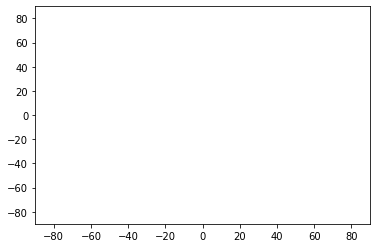

In [75]:
plus_indexes = coor_e1 > 0

plt.xlim(-90, 90)
plt.ylim(-90, 90)

curve_x = []
curve_y = []

# for phi, lam, c_e1 in zip(phis, lams, coor_e1):
#     if c_e1 <0:
#         curve_x = []
#         curve_y = []
#     else:
#         curve_x.append(phi)
#         curve_y.append(lam)
#         plt.xlim(-90, 90)
#         plt.ylim(-90, 90)
#         plt.plot(curve_x, curve_y)
#         plt.show()
# # plt.plot(phis[plus_indexes], lams[plus_indexes])
# # plt.show()

# print(coor_e1)

In [74]:
import plotly.graph_objects as go

local_frames = [go.Frame(data=go.Scatter(x=[p], y=[l], text=str(txt)))  for p, l, c, txt in zip(phis, lams, coor_e1, time_points) if c > 0]

fig = go.Figure(
    data=[go.Scatter(x=phis, y=lams, text=time_points)],
    layout=go.Layout(
        xaxis=dict(range=[-90, 90], autorange=False),
        yaxis=dict(range=[-90, 90], autorange=False),
        title="Start Title",
        transition= {'duration':1 },
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 100},}])])]
    ),
    frames=local_frames
)

fig.show()